# Baseline - 3D CNN

Baseline notebook using

**3D images**
* each image has the following shape: Channel x Width x Height x Depth
* *channel:* the channel represents a specific MRI type. Further, each image contains all four MRI types (i.e., channel=4)
* *depth:* the depth represents the depth or the number of slices. I tried various values >= 30. Caution: If for a given id, <= depth slices were available, I replaced the missing depth slices with zero matrices
* added some albumentation such as CLAHE, brightness, and CoarseDropout
* removed black pixels (see (here)[https://www.kaggle.com/furcifer/torch-efficientnet3d-for-mri-no-train]

**3D CNN**
* 4x Conv3d layers
* 3x MaxPool3d layers
* 1x AdaptiveMaxPool3d layers
* 2x fc layers

#### Imports

In [1]:
import os
import random
import glob
import re

import pandas as pd

import numpy as np

from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, utils

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import cv2

import albumentations as A

from tqdm import tqdm

import wandb

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

#### Seed

In [2]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True


set_seed(42)

#### Config

In [3]:
PATH = '..'

config = dict(
    # Pre-processing
    SLICE_NUMBER = 50, # >= 30
    REMOVE_BLACK_BOUNDARIES = False,
    DATASET='PNG',
    # Albumentation
    RRC_SIZE = 256,
    RRC_MIN_SCALE = 0.85,
    RRC_RATIO = (1., 1.),
    CLAHE_CLIP_LIMIT = 2.0,
    CLAHE_TILE_GRID_SIZE = (8, 8),
    CLAHE_PROB = 0.50,
    BRIGHTNESS_LIMIT = (-0.2,0.2),
    BRIGHTNESS_PROB = 0.40,
    HUE_SHIFT = (-15, 15),
    SAT_SHIFT = (-15, 15),
    VAL_SHIFT = (-15, 15),
    HUE_PROB = 0.64,
    COARSE_MAX_HOLES = 16,
    COARSE_PROB = 0.7,
    # Training
    N_EPOCHS = 10,
    BATCH_SIZE = 8,
    LEARNING_RATE = 0.01,
    # Logging
    VERBOSE = False,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### wandb

In [4]:
os.environ["WANDB_NOTEBOOK_NAME"] = "01-3D-BaseCNN"
wandb.login()
run = wandb.init(project='rsna-miccai', config=config)
config = wandb.config

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find 01-3D-BaseCNN
wandb: Currently logged in as: gusto (use `wandb login --relogin` to force relogin)


### 1. Load Data

For each person, we were given *four* different MRI types: 
* FLAIR
* T1w
* T1wCE, and 
* T2w. 

We will create 3D images which are composed of each MRI type (4 sequences) where each sequence is composed of *slice_number* (e.g. 50) slices (i.e., depth).<br>
Shape:  *Channel x Width x Height x Depth*


### 1.1 Utilities

#### 1.1.1 Augmentation

In [5]:
train_transform = A.Compose([
    A.RandomResizedCrop(
        config.RRC_SIZE, config.RRC_SIZE,            
        scale=(config.RRC_MIN_SCALE, 1.0),
        ratio=config.RRC_RATIO,
        p=1.0
    ),
    A.CLAHE(
        clip_limit=config.CLAHE_CLIP_LIMIT,
        tile_grid_size=config.CLAHE_TILE_GRID_SIZE,
        p=config.CLAHE_PROB
    ),
    A.RandomBrightnessContrast(
        brightness_limit=config.BRIGHTNESS_LIMIT,
        p=config.BRIGHTNESS_PROB
    ),
    A.HueSaturationValue(
        hue_shift_limit=config.HUE_SHIFT, 
        sat_shift_limit=config.SAT_SHIFT, 
        val_shift_limit=config.VAL_SHIFT, 
        p=config.HUE_PROB
    ),
    A.CoarseDropout(
        max_holes=config.COARSE_MAX_HOLES,
        p=config.COARSE_PROB),
])

valid_transform = A.Compose([
    A.RandomResizedCrop( 
        config.RRC_SIZE, config.RRC_SIZE,            
        scale=(config.RRC_MIN_SCALE, 1.0),
        ratio=config.RRC_RATIO,
        p=1.0
    )
])

#### 1.1.2 Loading Images

In [6]:
def get_slices(mri_type, aug):
    if config.VERBOSE:
        print(f"Length of folder: {len(mri_type)}")
    # Take SLICE_NUMBER slices from the middle
    threshold = config.SLICE_NUMBER // 2
    minimum_idx = len(mri_type)//2 - threshold if (len(mri_type)//2 - threshold) > 0 else 0
    maximum_idx = len(mri_type)//2 + threshold  # maximum can exceed the index
    if config.VERBOSE:
        print(f"Minimum {minimum_idx}")
        print(f"Maximum {maximum_idx}")
    # Create array which contains the images
    mri_img = []
    for file in mri_type[minimum_idx:maximum_idx]:
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        if config.REMOVE_BLACK_BOUNDARIES:
            (x, y) = np.where(img > 0)
            if len(x) > 0 and len(y) > 0:
                x_mn = np.min(x)
                x_mx = np.max(x)
                y_mn = np.min(y)
                y_mx = np.max(y)
                if (x_mx - x_mn) > 10 and (y_mx - y_mn) > 10:
                    img = img[:,np.min(y):np.max(y)]
        if aug:
            transformed = train_transform(image=img)
            img = transformed["image"]
        else:
            transformed = valid_transform(image=img)
            img = transformed["image"]
        mri_img.append(np.array(img))
    mri_img = np.array(mri_img).T
    # If less than SLICE_NUMBER slices, add SLICE_NUMBER - mri_img.shape[-1] images with only zero values
    if mri_img.shape[-1] < config.SLICE_NUMBER:
        if config.VERBOSE:
            print(f"Current slices: {mri_img.shape[-1]}")
        n_zero = config.SLICE_NUMBER - mri_img.shape[-1]
        mri_img = np.concatenate((mri_img, np.zeros((config.RRC_SIZE, config.RRC_SIZE, n_zero))), axis = -1)
    if config.VERBOSE:
        print(f"Shape of mri_img: {mri_img.shape}")
    return mri_img
    

def load_images(scan_id, aug=True):
    # Ascending sort
    flair = sorted(glob.glob(f"{PATH}/train/{scan_id}/FLAIR/*.png"), key=lambda f: int(re.sub('\D', '', f)))
    t1w = sorted(glob.glob(f"{PATH}/train/{scan_id}/T1w/*.png"), key=lambda f: int(re.sub('\D', '', f)))
    t1wce = sorted(glob.glob(f"{PATH}/train/{scan_id}/T1wCE/*.png"), key=lambda f: int(re.sub('\D', '', f)))
    t2w = sorted(glob.glob(f"{PATH}/train/{scan_id}/T2w/*.png"), key=lambda f: int(re.sub('\D', '', f)))
    
    if config.VERBOSE:
        print(f"Scan id {scan_id}")
    flair_img = get_slices(flair, aug)
    t1w_img = get_slices(t1w, aug)
    t1wce_img = get_slices(t1wce, aug)
    t2w_img = get_slices(t2w, aug)
    
    # Return 3D image: ChannelsxWidthxHeightxDepth
    return np.moveaxis(np.array((flair_img, t1w_img, t1wce_img, t2w_img)), 0, 0)

#### Example

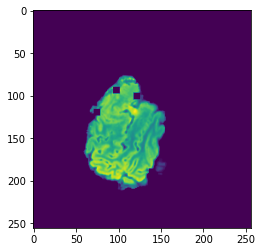

In [7]:
slices_aug = load_images("00002", aug=True)
one_sclice = slices_aug[0,:,:,0]
plt.imshow(one_sclice)
plt.show()

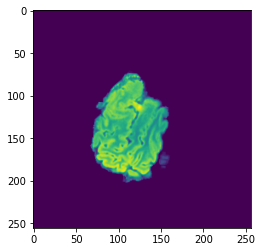

In [8]:
slices = load_images("00002", aug=False)
one_sclice = slices[0,:,:,0]
plt.imshow(one_sclice)
plt.show()

### 1.2 Dataset and Dataloader

In [9]:
class RSNADataset(Dataset):
    def __init__(self, path='../', split = "train", validation_split = 0.2):
        train_data = pd.read_csv(os.path.join(path, 'train_labels.csv'))
        self.labels = {}
        brats = list(train_data["BraTS21ID"])
        mgmt = list(train_data["MGMT_value"])
        for b, m in zip(brats, mgmt):
            self.labels[str(b).zfill(5)] = m
            
        remove_ids = ["00709", "00109", "00123"]
            
        if split == "valid":
            self.split = split
            self.ids = [a.split("/")[-1] for a in sorted(glob.glob((path + f"/train/" + "/*")), key=lambda f: int(re.sub('\D', '', f)))]
            self.ids = self.ids[:int(len(self.ids) * validation_split)] # first 20% as validation
        elif split == "train":
            self.split = split
            self.ids = [a.split("/")[-1] for a in sorted(glob.glob((path + f"/train/" + "/*")), key=lambda f: int(re.sub('\D', '', f)))]
            self.ids = self.ids[int(len(self.ids) * validation_split):] # last 80% as train
        elif split == "test":
            self.split = split
            self.ids = [a.split("/")[-1] for a in sorted(glob.glob((path + f"/test/" + "/*")), key=lambda f: int(re.sub('\D', '', f)))]
        else:
            self.split = split
            self.ids = [a.split("/")[-1] for a in sorted(glob.glob((path + f"/train/" + "/*")), key=lambda f: int(re.sub('\D', '', f)))]
        
        self.ids = [id_ for id_ in self.ids if id_ not in remove_ids]            
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        if self.split == "train":
            imgs = load_images(self.ids[idx], aug=True)
        else:
            imgs = load_images(self.ids[idx], aug=False)
        imgs = imgs - imgs.min()
        imgs = (imgs + 1e-5) / (imgs.max() - imgs.min() + 1e-5)

        if self.split != "test":
            label = self.labels[self.ids[idx]]
            return torch.tensor(imgs, dtype = torch.float32), torch.tensor(label, dtype = torch.long)
        else:
            return torch.tensor(imgs, dtype = torch.float32)

In [10]:
train_ds = RSNADataset()
train_dl = DataLoader(train_ds, batch_size=config.BATCH_SIZE, shuffle=True)
valid_ds = RSNADataset(split='valid')
valid_dl = DataLoader(valid_ds, batch_size=config.BATCH_SIZE, shuffle=False)

In [11]:
images, labels = next(iter(train_dl))
print(f"Shape of the batch {images.shape}")
print(f"Batch size: {images.shape[0]}")
print(f"Number of channels each image has: {images.shape[1]}")
print(f"Size of each image is: {images.shape[2]}x{images.shape[3]}")
print(f"Depth of each channel/sequence: {images.shape[-1]}")

Shape of the batch torch.Size([8, 4, 256, 256, 50])
Batch size: 8
Number of channels each image has: 4
Size of each image is: 256x256
Depth of each channel/sequence: 50


### 1.3 Model

In [12]:
class GliobCNN(nn.Module): 
    def __init__(self):
        super(GliobCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv3d(in_channels=4, out_channels=64, kernel_size=3, stride=1)
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=32, kernel_size=3, stride=1)
        self.conv3 = nn.Conv3d(in_channels=32, out_channels=16, kernel_size=3, stride=1)
        self.conv4 = nn.Conv3d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1)
        
        # Pooling layers
        self.pooling1 = nn.MaxPool3d(kernel_size=3, stride=2)
        self.pooling2 = nn.MaxPool3d(kernel_size=3, stride=2)
        self.pooling3 = nn.MaxPool3d(kernel_size=3, stride=2)
        self.pooling4 = nn.AdaptiveMaxPool3d(10)
        
        # Fully connected layers
        self.fc1 = nn.Linear(8000, 4096)
        self.fc2 = nn.Linear(4096, 2)

    def forward(self, X):
        
        X = F.relu(self.conv1(X))
        X = self.pooling1(X)   
        X = F.relu(self.conv2(X))
        X = self.pooling2(X)
        X = F.relu(self.conv3(X))
        X = self.pooling3(X)
        X = F.relu(self.conv4(X))
        X = self.pooling4(X)       # 8x10x10x10
        X = X.flatten(1)           # 8000
        X = F.relu(self.fc1(X))    # 4096
        X = self.fc2(X)            # 2

        return X

In [13]:
model = GliobCNN()

### 1.4 Training

In [14]:
def one_hot(arr):
    return [[1, 0] if a_i == 0 else [0, 1] for a_i in arr]

def training(net, n_epochs, optimizer, loss_function, scheduler):
    wandb.watch(net, loss_function, log='all', log_freq=10)
    # Store the losses for each epoch
    loss_train_list = []
    loss_valid_list = []

    # Store the roc for each epoch
    roc_train_list = []
    roc_valid_list = []
    
    best_roc = 0.0

    # Iterate over the dataset n_epochs times
    for epoch in range(n_epochs):
        net.train()  # net.train() will notify all your layers that you are in training mode

        train_loss = 0  # Training loss in epoch
        y_train_list = []
        y_hat_train_list = []
        roc_train = 0.0

        # For each batch, pass the training examples, calculate loss and gradients and optimize the parameters
        for xb, yb in tqdm(train_dl, desc="Training"):
            optimizer.zero_grad()  # zero_grad clears old gradients from the last step

            xb = xb.to(device)
            yb = yb.to(device)

            y_hat = net(xb)  # Forward pass
            loss = loss_function(y_hat, yb)  # Calculate Loss

            loss.backward()  # Calculate the gradients (using backpropagation)
            optimizer.step()  # # Optimize the parameters: opt.step() causes the optimizer to take a step based on the gradients of the parameters.

            train_loss += loss.item()
            y_train_list.extend(yb.tolist())
            y_hat_train_list.extend(y_hat.tolist())

        roc_train += roc_auc_score(one_hot(y_train_list), y_hat_train_list)
                
        wandb.log({"epoch": epoch, "train_loss": train_loss, "train_roc": roc_train})

        valid_loss = 0  # Validation loss in epoch
        y_valid_list = []
        y_hat_valid_list = []
        roc_valid = 0.0

        net.eval()  # net.eval() will notify all your layers that you are in evaluation mode
        with torch.no_grad():
            # Perform a prediction on the validation set  
            for xb_valid, yb_valid in tqdm(valid_dl, desc="Validation"):
                xb_valid = xb_valid.to(device)
                yb_valid = yb_valid.to(device)

                y_hat = net(xb_valid)  # Forward pass
                loss = loss_function(y_hat, yb_valid)  # Calculate Loss

                valid_loss += loss.item()
                y_valid_list.extend(yb_valid.tolist())
                y_hat_valid_list.extend(y_hat.tolist())

        roc_valid += roc_auc_score(one_hot(y_valid_list), y_hat_valid_list)
        scheduler.step(valid_loss)

        wandb.log({"epoch": epoch, "test_loss": valid_loss, "test_roc": roc_valid})

        loss_train_list.append(train_loss)
        loss_valid_list.append(valid_loss)
        roc_train_list.append(roc_train)
        roc_valid_list.append(roc_valid)
        
        if roc_valid > best_roc:
            best_roc = roc_valid
            torch.save(net.state_dict(), f'../models/02-3D-ResNet18-roc-{round(best_roc, 2)}.pt')

    return roc_train_list, roc_valid_list, loss_train_list, loss_valid_list

In [15]:
# Create Loss Function
loss_function = nn.CrossEntropyLoss()

# Create optimizer
optimizer = torch.optim.SGD(model.parameters(),lr = config.LEARNING_RATE)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.25)

model.to(device)

roc_train, roc_valid, loss_train, loss_valid = training(model, config.N_EPOCHS, optimizer, loss_function, scheduler)

Validation: 100%|██████████| 15/15 [00:56<00:00,  3.76s/it]


In [18]:
run.finish()

Run pip install nbformat to save notebook history


epoch,9
train_loss,40.22736
train_roc,0.58412
_runtime,3466
_timestamp,1627488799
_step,19
test_loss,10.32867
test_roc,0.54955


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_loss,██▇▇▆▆▃▂▂▁
train_roc,▁▂▃▄▇▆▇▇▇█
_runtime,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_loss,▄▄▄▄▄▂▁█▇▁
test_roc,▆██▅▆▃▃▁▂▁


Done